In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_swissroll_path = os.path.join(cwd, '..', 'models_swissroll', 'wasserstein')
sys.path.append(api_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           xtry_langevin_sampling_plot_2d,
                           epoch_visualization)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          xtry_langevin_sampling,
                          gan_energy,
                          Gaussian_mixture,
                          IndependentNormal,
                          DotDict)
from params_swissroll_wasserstein import (sigma,
                                          random_seed,
                                          train_dataset_size,
                                          n_dim,
                                          n_layers_d,
                                          n_layers_g,
                                          n_hid_d,
                                          n_hid_g,
                                          n_out,
                                          device)

from metrics import Evolution, plot_chain_metrics

# Swissroll, Gaussians

In [14]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train = prepare_swissroll_data(train_dataset_size)
X_train_std = X_train

In [4]:
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [7]:
discriminator_regexp = os.path.join(models_swissroll_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_swissroll_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [8]:
G.load_state_dict(torch.load(generator_name, map_location=device))
D.load_state_dict(torch.load(discriminator_name, map_location=device))

<All keys matched successfully>

In [9]:
G = G.to(device)
D = D.to(device)

In [10]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [11]:
%autoreload

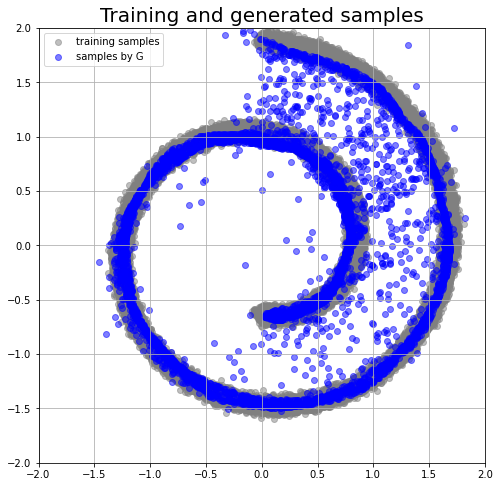

In [15]:
batch_size_sample = 5000
x_range = 2.0
y_range = 2.0
sample_fake_data(G, X_train,
                 x_range,
                 y_range,
                 batch_size_sample = batch_size_sample)

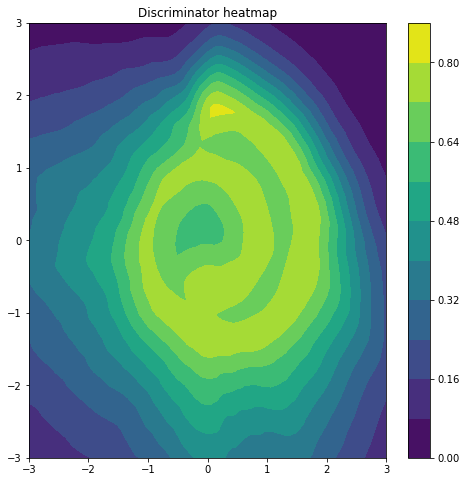

In [16]:
x_range = 3.0
y_range = 3.0
plot_discriminator_2d(D,
                      x_range,
                      y_range,
                      num_points = 700)

Start to do MH sampling....


100%|██████████| 5000/5000 [01:10<00:00, 71.37it/s]


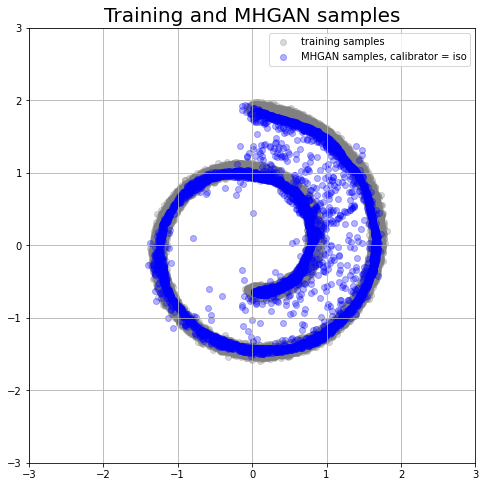

In [17]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_calib_pts = n_calib_pts,
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1)

In [18]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normal = Normal(loc, scale)
normalize_to_0_1 = True 
log_prob = True

target_gan = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = normal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


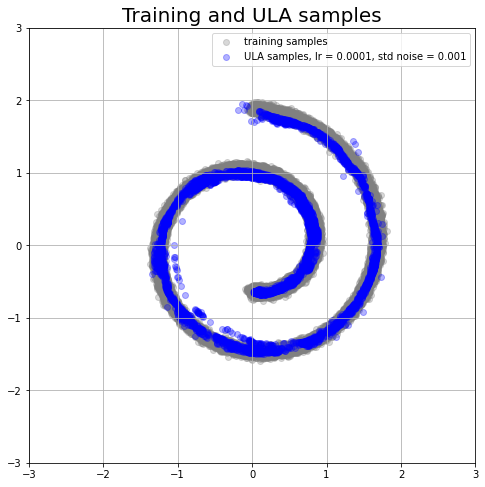

In [22]:
grad_step = 1e-4
eps_scale = 1e-3
n_steps = 1000
n_batches = 10
langevin_sampling_plot_2d(target_gan,
                          proposal,
                          X_train,  
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches,
                          latent_transform = G)

In [44]:
%autoreload

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


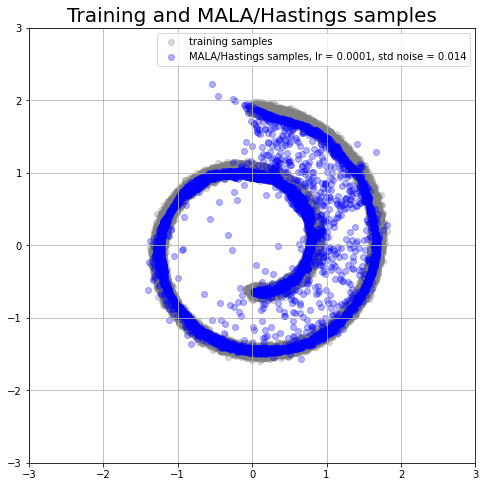

In [58]:
grad_step = 1e-4
eps_scale = (2*grad_step)**0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Hastings'
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,   
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      latent_transform = G)

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


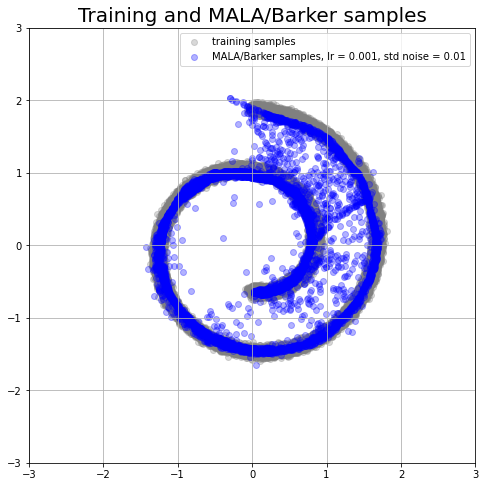

In [46]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 100
n_batches = 10
acceptance_rule = 'Barker'
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      latent_transform = G)

100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


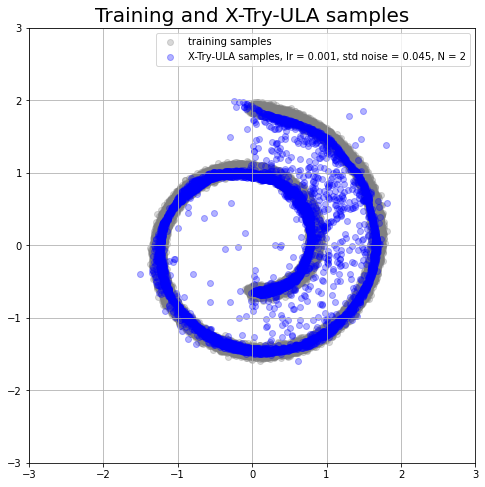

In [56]:
grad_step = 1e-3
eps_scale = (2*grad_step)**(0.5)
n_steps = 100
n_batches = 10
N = 2
xtry_langevin_sampling_plot_2d(target_gan,
                               proposal,
                               X_train,  
                               batch_size_sample = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               N = N,
                               n_steps = n_steps,
                               n_batches = n_batches,
                               latent_transform = G)